In [8]:
file = '../JMiPOD/00002.jpg'

In [ ]:
with open(file, 'rb') as image:
    img = image.read()

In [ ]:
image_stream = bytearray(img)

In [ ]:
img

In [ ]:
image = [b for b in img]
image[:10]

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
bytearray(img[:10])

In [9]:
import math
import struct
import sys


# Marker symbols (X'FFxx')
MSYM = {'SOF0': 0xC0, 'SOF1': 0xC1, 'SOF2': 0xC2, 'SOF3': 0xC3, 'SOF5': 0xC5,
        'SOF6': 0xC6, 'SOF7': 0xC7, 'JPG': 0xC8, 'SOF9': 0xC9, 'SOF10': 0xCA,
        'SOF11': 0xCB, 'SOF13': 0xCD, 'SOF14': 0xCE, 'SOF15': 0xCF,
        'DHT': 0xC4, 'DAC': 0xCC, 'SOI': 0xD8, 'EOI': 0xD9, 'SOS': 0xDA,
        'DQT': 0xDB, 'DNL': 0xDC, 'DRI': 0xDD, 'DHP': 0xDE, 'EXP': 0xDF, 'COM': 0xFE}
MSYM.update({f'RST{m}': 0xD0 + m for m in range(8)})   # RST0..RST7
MSYM.update({f'APP{n}': 0xE0 + n for n in range(16)})  # APP0..APP15
MSYM.update({f'JPG{n}': 0xF0 + n for n in range(14)})  # APP0..APP13

# Zig-zag sequence
ZZ = [0,  1,  5,  6,  14, 15, 27, 28,
      2,  4,  7,  13, 16, 26, 29, 42,
      3,  8,  12, 17, 25, 30, 41, 43,
      9,  11, 18, 24, 31, 40, 44, 53,
      10, 19, 23, 32, 39, 45, 52, 54,
      20, 22, 33, 38, 46, 51, 55, 60,
      21, 34, 37, 47, 50, 56, 59, 61,
      35, 36, 48, 49, 57, 58, 62, 63]


class NoMoreData(Exception):
    pass

class BrokenByteStuff(Exception):
    def __init__(self, stuff):
        self.stuff = stuff

# byte/bit stream reader
class Reader():
    def __init__(self, filename):
        self.fs = open(filename, 'rb')
        self.blen = 0
        self.bbuf = 0
    # read n-bytes (as byte type)
    def byte_raw(self, n):
        b = self.fs.read(n)
        if len(b) < n:
            raise NoMoreData()
        return b
    # read n-bytes
    def byte(self, n):
        return int.from_bytes(self.byte_raw(n), 'big')
    # read n-bits
    def bits(self, n):
        ret = 0
        while 0 < n:
            if self.blen == 0:
                b = self.fs.read(1)
                if b == b'\xFF':
                    # X'FF00' -> 0xff(256)
                    stuff = self.fs.read(1)
                    if stuff != b'\x00':
                        raise BrokenByteStuff(stuff)
                self.bbuf = int.from_bytes(b, 'big')
                self.blen = 8
            m = min(n, self.blen)
            lb = (self.bbuf >> (self.blen - m)) & ((1 << m) - 1)
            ret = (ret << m) | lb
            self.blen -= m
            n -= m
        return ret
    # byte aligned?
    def byte_aligned(self):
        return self.blen == 0
    def __enter__(self):
        return self
    def __exit__(self, type, value, traceback):
        self.fs.close()


# Huffman decoder
class HuffmanDecoder():
    def __init__(self, hufftbl):
        self.huffval, self.huffsize, self.huffcode = hufftbl
    # decode Huffman code
    def code(self, r):
        code, sz = 0, 0
        for i, n in enumerate(self.huffsize):
            if sz < n:
                m, sz = n - sz, n
                code = (code << m) | r.bits(m)
            if self.huffcode[i] == code:
#                 print(f'Huffman: {code:0{sz}b} -> {self.huffval[i]}')
                return self.huffval[i]
        assert False, "broken Huffman code"
    # decode one value
    def value(self, r, n):
        b = r.bits(n)
        if b < (1 << (n - 1)):
            return b - ((1 << n) - 1)  # neg. value
        else:
            return b  # pos. value


# decode HUFFVAL/HUFFSIZE/HUFFCODE
def decode_hufftable(v):
    huffval = []
    huffsize = []
    for i, w in enumerate(v):
        huffval.extend(w)
        huffsize += [i + 1] * len(w)
    huffsize += [0]

    huffcode = [0] * len(huffval)
    si = huffsize[0]
    code = 0
    k = 0
    while True:
        while True:
            huffcode[k] = code
            k += 1
            code += 1
            if huffsize[k] != si:
                break
        if huffsize[k] == 0:
            break
        while True:
            code <<= 1
            si += 1
            if huffsize[k] == si:
                break
    return (huffval, huffsize, huffcode)


# DC code table
def decode_dccode(r, hdec, pred):
    ssss = hdec.code(r)
    if ssss == 0:
#         print(f'DC diff=0 pred={pred:+d}')
        return pred
    assert ssss <= 15, "DC magnitude category <= 15"
    diff = hdec.value(r, ssss)
#     print(f'DC s={ssss} diff={diff:+d} pred={pred:+d}')
    return diff + pred


# AC code table
def decode_accode(r, hdec):
    rs = hdec.code(r)
    rrrr, ssss = rs >> 4, rs & 0b1111
    if ssss == 0:
#         print('AC ' + 'EOB' if rrrr == 0 else 'ZRL')
        return (rrrr, 0)  # EOB/ZRL
    val = hdec.value(r, ssss)
#     print(f'AC r={rrrr} s={ssss} val={val:+d}')
    return (rrrr, val)


# # inverse DCT (naive formula implementation in CCITT Rec. T.81)
# def idct_naive(coeff):
#     def cos16(x):
#         return math.cos(x * math.pi / 16)
#     block = [0] * 64
#     for i in range(64):
#         y, x = i // 8, i % 8
#         s = 0
#         for j in range(64):
#             v, u = j // 8, j % 8
#             cu = 1 / math.sqrt(2) if u == 0 else 1
#             cv = 1 / math.sqrt(2) if v == 0 else 1
#             s += cu * cv * coeff[j] * cos16((2 * x + 1) * u) * cos16((2 * y + 1) * v)
#         block[i] = s / 4
#     return block

# # inverse DCT (LUT implementation)
# COS_LUT = [[math.cos((2 * xy + 1) * uv * math.pi / 16) for uv in range(8)] for xy in range(8)]
# INVSQRT2 = 1 / math.sqrt(2)
# def idct_lut(coeff):
#     block = [0] * 64
#     for i in range(64):
#         y, x = i // 8, i % 8
#         s = 0
#         for j in range(64):
#             v, u = j // 8, j % 8
#             cu = INVSQRT2 if u == 0 else 1
#             cv = INVSQRT2 if v == 0 else 1
#             s += cu * cv * coeff[j] * COS_LUT[x][u] * COS_LUT[y][v]
#         block[i] = s / 4
#     return block

# idct = idct_lut


# decode 8x8 block
def decode_block8x8(r, hdec, pred, qtbl, bpp):
    sq = [0] * 64
    # decode DC coefficient
    sq[0] = decode_dccode(r, hdec[0], pred)
    pred = sq[0]
    # decode AC coefficients (in Zig-Zag order)
    k = 1
    while k < 64:
        run, val = decode_accode(r, hdec[1])
        if (run, val) == (0, 0):  # EOB
            break
        k += run
        assert k < 64, f'out of range: k={k} run/val={run}/{val}'
        sq[k] = val
        k += 1
#     print(f'  Sq={sq[:k]}...')
    # dequantize
    for i in range(64):
        sq[i] *= qtbl[i]
#     print(f'  Rz={sq[:k]}...')
    # reorder Zig-Zag to coding order
    coeff = [0] * 64
    for i, z in enumerate(ZZ):
        coeff[i] = sq[z]
#     print(f'  Ri=' + str([coeff[i:i + 8] for i in range(0, 64, 8)]))
    # inverse DCT
#     block = idct(coeff)
    # No need to invert and level shift
    block = coeff
#     # level shift
#     shift = 1 << (bpp - 1)
#     maxval = (1 << bpp) - 1
#     for i in range(64):
#         block[i] = min(max(0, round(block[i] + shift)), maxval)
#     print(f'  I=' + str([block[i:i + 8] for i in range(0, 64, 8)]))
    return (block, pred)


# Entropy-coded data segments
def decode_scan(r, image, scan):
    assert scan['SS'] == (0, 63), "SpectralSelection is not supported"
    assert scan['SA'] == (0, 0), "SuccessiveApproximation is not supported"

    nmcu = image['F']['nmcu']
    bpp = image['F']['bit']  # bit per pixel
    recimg = image['I']

    # components in current scan
    scan_component = []
    for sc in scan['C']:
        scan_component += [c for c in image['C'] if c['C'] == sc['Cs']]
    # block list in MCU
    blocks = []
    for c in scan_component:
        for cv in range(c['V']):
            for ch in range(c['H']):
                blocks.append((c['i'], ch, cv))
    # set QuantizationTables
    qtbl = []
    for c in scan_component:
        qtbl.append(image['QT'][c['Tq']])
    # initalize HuffmanDecoders
    hdec = []
    for c in scan['C']:
        hdec.append(HuffmanDecoder(image['HT'][c['Td'] * 2]))      # DC
        hdec.append(HuffmanDecoder(image['HT'][c['Ta'] * 2 + 1]))  # AC
    # initialize DC predictors
    pred = [0] * len(scan)

    # decode MCUs
    reset_interval = image['RI']
    MRST = {v: k for k, v in MSYM.items() if k[:3] == 'RST'}
    for mcu_idx in range(nmcu[0] * nmcu[1]):
        mcu_y, mcu_x = mcu_idx // nmcu[0], mcu_idx % nmcu[0]
        if 0 < reset_interval and 0 < mcu_idx and mcu_idx % reset_interval == 0:
            # align byte
            while not r.byte_aligned():
                b = r.bits(1)
                assert b == 1, 'invalid bits for byte alignment'
            # read restart marker
            marker = r.byte_raw(2)
            assert marker[0] == 0xFF and marker[1] in MRST, 'invalid RSTm marker'
#             print(MRST[marker[1]])
            # reset DC predictors
            pred = [0] * len(scan)
        for ci, bx, by in blocks:
            # decode 8x8 block
            blk_x = mcu_x * scan_component[ci]['H'] + bx
            blk_y = mcu_y * scan_component[ci]['V'] + by
#             print(f'MCU#{mcu_idx}: C[{ci}] pos={blk_x},{blk_y}')
            blkimg, pred[ci] = decode_block8x8(r, hdec[ci * 2:ci * 2 + 2], pred[ci], qtbl[ci], bpp)
            # copy 8x8 block to image
            stride = scan_component[ci]['size'][0]
            for i in range(8):
                offset = (blk_y * 8 + i) * stride + blk_x * 8
                recimg[ci][offset:offset + 8] = blkimg[i * 8:(i + 1) * 8]


# Frame header
def parse_SOFn(r, n, image):
    lf = r.byte(2)
    p = r.byte(1)
    y = r.byte(2)
    x = r.byte(2)
    nf = r.byte(1)
#     print(f'SOF{n}: Lf={lf} P={p} Y={y} X={x} Nf={nf}')
    component = [{}] * nf
    for i in range(nf):
        c = r.byte(1)
        b = r.byte(1)
        h, v = b >> 4, b & 0b1111
        tq = r.byte(1)
        component[i] = {'i': i, 'C': c, 'H': h, 'V': v, 'Tq': tq}
#         print(f'  Component[{i}]: C={c} H={h} V={v} Tq={tq}')
    lf -= 8 + 3 * nf
    assert lf == 0, "invalid SOF payload"
    # check QuantizationTable
    for c in component:
        assert image['QT'][c['Tq']], "QuantizationTable not found"
    # register frame/component
    mcu_h = max(c['H'] * 8 for c in component)
    mcu_v = max(c['V'] * 8 for c in component)
    nmcu = (math.ceil(x / mcu_h), math.ceil(y / mcu_v))
    image['F'] = {'bit': p, 'size': (x, y), 'nmcu': nmcu}
    image['C'] = component
    for c in image['C']:
        c['size'] = (nmcu[0] * c['H'] * 8, nmcu[1] * c['V'] * 8)
    # allocate reconstruct image buffer
    image['I'] = []
    shift = 1 << (p - 1)  # Y=gray / CbCr=zero
    for c in component:
        rec_x, rec_y = nmcu[0] * c['H'] * 8, nmcu[1] * c['V'] * 8
        image['I'].append([shift] * (rec_x * rec_y))
#         print('  RecImg[{}]: C={} size={}x{}'.format(c['i'], c['C'], rec_x, rec_y))


# Scan header
def parse_SOS(r, image):
    ls = r.byte(2)
    ns = r.byte(1)
#     print(f'SOS: Ls={ls} Ns={ns}')
    component = [{}] * ns
    for j in range(ns):
        cs = r.byte(1)
        b = r.byte(1)
        td, ta = b >> 4, b & 0b1111
        component[j] = {'Cs': cs, 'Td': td, 'Ta': ta}
#         print(f'  Component[{j}]: Cs={cs} Td={td} Ta={ta}')
    ss = r.byte(1)
    se = r.byte(1)
    b = r.byte(1)
    ah, al = b >> 4, b & 0b1111
    ls -= 6 + 2 * ns
#     print(f'  Ss={ss} Se={se} Ah={ah} Al={al}')
    assert ls == 0, "invalid SOS payload"
    # check HuffmanTables
    for sc in component:
        assert image['HT'][sc['Td'] * 2], "HuffmanTable/DC does not found"
        assert image['HT'][sc['Ta'] * 2 + 1], "HuffmanTable/AC does not found"
    # SS=spectral selection, SA=successive approximation
    return {'SS': (ss, se), 'SA': (ah, al), 'C': component}


# Quantization table-specification
def parse_DQT(r, image):
    lq = r.byte(2)
#     print(f'DQT: Lq={lq}')
    lq -= 2
    t = 0
    while 0 < lq:
        b = r.byte(1)
        pq, tq = b >> 4, b & 0b1111
        n = 1 if pq == 0 else 2
        q = [0] * 64
        for k in range(64):
            q[k] = r.byte(n)
#         print(f'  DQT[{t}]: Pq={pq} Tq={tq} Q_k={q}')
        # register QuantizationTable
        image['QT'][tq] = q
        lq -= 1 + 64 * n
        t += 1
    assert lq == 0, "invalid DQT payload"


# Huffman table-specification
def parse_DHT(r, image):
    lh = r.byte(2)
#     print(f'DHT: Lh={lh}')
    lh -= 2
    t = 0
    while 0 < lh:
        b = r.byte(1)
        tc, th = b >> 4, b & 0b1111
        l = [0] * 16  # BITS
        for i in range(16):
            l[i] = r.byte(1)
        v = [[]] * 16  # HUFFVAL
        for i in range(16):
            if l[i] == 0:
                continue
            v[i] = [0] * l[i]
            for j in range(l[i]):
                v[i][j] = r.byte(1)
#         print(f'  DHT[{t}]: Tc={tc} Th={th} L_i={l} V_ij={v}')
        lh -= 1 + 16 + sum(l)
        # decode HuffmanTable
        hv, hs, hc = decode_hufftable(v)
        if tc == 0:
            hv_s = ', '.join([str(v) for v in hv])
        else:
            def achv2str(rs):
                r, s = rs >> 4, rs & 0b1111
                return ('ZRL' if r == 0 else f'EOB{r}') if s == 0 else f'{r}/{s}'
            hv_s = ', '.join([achv2str(v) for v in hv])
        hc_s = ', '.join(['{n:0{s}b}'.format(n=c, s=hs[i]) for i, c in enumerate(hc)])
#         print(f'  DHT[{t}]: HUFFVAL=[{hv_s}]')
#         print(f'  DHT[{t}]: HUFFCODE=[{hc_s}]')
        # register HuffmanTable
        image['HT'][th * 2 + tc] = (hv, hs, hc)
        t += 1
    assert lh == 0, "invalid DHT payload"


# Restart interval definition syntax
def parse_DRI(r, image):
    lr = r.byte(2)
    ri = r.byte(2)
#     print(f'DRI: Lr={lr} Ri={ri}')
    lr -= 4
    assert lr == 0, 'invalid DRI payload'
    image['RI'] = ri


# Application data
def parse_APPn(r, n):
    la = r.byte(2)
    if n == 0:
        identifier = r.byte_raw(5)
        if identifier == b'JFIF\x00':
            version = r.byte(2)
            units = r.byte(1)
            h_dens = r.byte(2)
            v_dens = r.byte(2)
            h_thumb = r.byte(1)
            v_thumb = r.byte(1)
#             print(f'APP0: La={la} {identifier} version={version:04X}'
#                   f' units={units} density={h_dens},{v_dens} thumbnail={h_thumb},{v_thumb}')
        else:
            print(f'APP0: La={la} {identifier} ...')
    else:
        ap = r.byte_raw(la - 2)
#         print(f'APP{n}: La={la} Ap={ap}')


# parse JPEG bytestream
def parse_stream(r):
    MARKER = {v: k for k, v in MSYM.items()}  # X'FFxx' -> marker symbol
    try:
        image = None
        while True:
            # search marker
            b = r.byte(1)
            if b != 0xFF:
                continue
            b = r.byte(1)
            if b == 0x00:
                continue
            m = MARKER.get(b, None)
            # parse marker
            if m == 'SOI':
                # 'Start of image' marker
#                 print(f'{m}')
                image = {'QT': [None] * 4,  # QuantizationTable (0..3)
                         'HT': [None] * 8,  # HuffmanTable (DC/AC, 0..3)
                         'RI': 0}           # Reset interval
            elif m == 'EOI':
                # 'End of image' marker
#                 print(f'{m}')
                return image
            elif m[:3] == 'SOF':
                # 'Start of frame' markers
                n = b - MSYM['SOF0']
                frame = parse_SOFn(r, n, image)
                assert n == 0, "support only SOF0/Baseline DCT"
            elif m == 'DQT':
                # 'Define quantization tables' marker
                parse_DQT(r, image)
            elif m == 'DHT':
                # 'Define Huffman tables' marker
                parse_DHT(r, image)
            elif m == 'DAC':
                # 'Define arithmetic coding conditionings' marker
                assert False, "Arithmetic coding is not supported"
            elif m == 'DRI':
                # 'Define restart interval' marker
                parse_DRI(r, image)
            elif m == 'SOS':
                # 'Start of scan' marker
                scan = parse_SOS(r, image)
                decode_scan(r, image, scan)
            elif m[:3] == 'APP':
                # 'Reserved for application segments' markers
                n = b - MSYM['APP0']
                parse_APPn(r, n)
            else:
                pass
#                 print(f'(ignore {m})')
    except NoMoreData:
        pass


# # YCbCr to RGB (BT.601 8bit)
# def to_rgb(y, cb, cr):
#     cb -= 128
#     cr -= 128
#     r = min(max(0, round(y               + 1.402  * cr)), 255)
#     g = min(max(0, round(y - 0.3441 * cb - 0.7141 * cr)), 255)
#     b = min(max(0, round(y + 1.772  * cb              )), 255)
#     return (r, g, b)


# # write image to PPM (portable pixmal format) file
# def write_ppm(image):
#     width, height = image['F']['size']
#     recimg = image['I']

#     nc = len(image['C'])
#     if nc == 1:
#         print(f'Y size={width}x{height}')
#     elif nc == 3:
#         # chroma downsample factor
#         ds_h = image['C'][0]['H'] // image['C'][1]['H']
#         ds_v = image['C'][0]['V'] // image['C'][1]['V']
#         print(f'YCbCr size={width}x{height} chroma={ds_h}x{ds_v}')
#     else:
#         assert False, "unknown color space"

#     # write PPM file
# #     with open(outfile, 'wb') as f:
# #         f.write(f'P6\n{width} {height}\n255\n'.encode('ascii'))
#     for y in range(height):
#         for x in range(width):
#             luma = recimg[0][y * width + x]
#             if nc == 3:
#                 offset = (y // ds_v) * (width // ds_h) + (x // ds_h)
#                 cb = recimg[1][offset]
#                 cr = recimg[2][offset]
#             else:
#                 cb = cr = 128
#             rgb = to_rgb(luma, cb, cr)
#     return luma, offset, cb, cr
# #             f.write(struct.pack('3B', *rgb)

In [10]:

def main(infile):
    with Reader(file) as r:
        image = parse_stream(r)
        
%timeit main(file)

4.06 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
with Reader(file) as r:
    image = parse_stream(r)

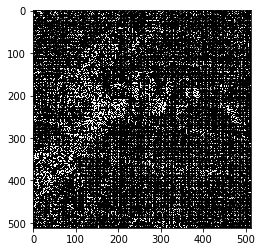

In [12]:
img_cov = np.array(image['I'])[0].reshape(512, 512)

plt.imshow(img_cov, cmap='gray' ,vmax = np.max(img_cov)*0.01,vmin = 0)

In [13]:
img_cov

array([[-882,   15,   13, ...,    0,    5,    0],
       [  -9,   -8,    9, ...,    0,   -6,    0],
       [   0,   -2,    2, ...,    0,    0,    0],
       ...,
       [  -2,    0,    0, ...,    0,    0,    0],
       [   5,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [ ]:
image.keys()

In [ ]:
def write_ppm(image):
    width, height = image['F']['size']
    recimg = image['I']

    nc = len(image['C'])
    if nc == 1:
        print(f'Y size={width}x{height}')
    elif nc == 3:
        # chroma downsample factor
        ds_h = image['C'][0]['H'] // image['C'][1]['H']
        ds_v = image['C'][0]['V'] // image['C'][1]['V']
        print(f'YCbCr size={width}x{height} chroma={ds_h}x{ds_v}')
    else:
        assert False, "unknown color space"

    # write PPM file
#     with open(outfile, 'wb') as f:
#         f.write(f'P6\n{width} {height}\n255\n'.encode('ascii'))
    for y in range(height):
        for x in range(width):
            luma = recimg[0][y * width + x]
            if nc == 3:
                offset = (y // ds_v) * (width // ds_h) + (x // ds_h)
                cb = recimg[1][offset]
                cr = recimg[2][offset]
            else:
                cb = cr = 128
            rgb = to_rgb(luma, cb, cr)
    return luma, offset, cb, cr, rgb


luma, offset, cb, cr, rgb = write_ppm(image)

# main(file, 'test')

In [ ]:
rgb

In [ ]:
image

In [ ]:
reader = JPEGFileReader(file)

In [ ]:
tables = dict()
for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
    if 'dc' in table_name:
        tables[table_name] = reader.read_dc_table()
    else:
        tables[table_name] = reader.read_ac_table()

In [ ]:
a = np.array([[-882, 15, 13, -18, 4, 4, -5, 6], [-8, -8, 9, 4, -3, 0, -6, -6], [0, -2, 2, 0, -4, 0, 0, 0], [1, 2, 4, 0, -5, 0, 0, 0], [-4, -4, 0, 6, 0, 0, 0, 0], [0, 4, -6, 0, 0, 0, 0, 0], [5, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
a.shape

In [ ]:
plt.imshow(a)